# LSTM_eda


## Mount Google Drive

In [1]:
# Colab 사용시
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install

In [2]:
# !java -version
%pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.1 MB/s 
     |████████████████████████████████| 453 kB 71.8 MB/s 


## Import Library

In [12]:
# data
import pandas as pd
import pickle

# preprocessing
from konlpy.tag import Komoran
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# env
import os
from tqdm import tqdm
# import hangul_font

ModuleNotFoundError: ignored

## GPU Check

In [4]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print('No GPU found')

GPU found


## Hyper parameters

In [8]:
# Path
# Colab
DATA_DIR = '/content/drive/MyDrive/miso/new_intelli/data/'
SAVE_DIR = '/content/drive/MyDrive/miso/new_intelli/model/LSTM_eda/'
LOAD_DIR = '/content/drive/MyDrive/miso/new_intelli/model/LSTM_eda/'

# Local
# DATA_DIR = '/Users/inseoklee/Desktop/miso/new_intelli/data/'
# SAVE_DIR = '/Users/inseoklee/Desktop/miso/new_intelli/model/LSTM_eda/'
# LOAD_DIR = '/Users/inseoklee/Desktop/miso/new_intelli/model/LSTM_eda/'

# Model
# MAX_LEN -> 패딩 단계에서 설정
OUTPUT_DIM = 128 # Embedding layer
UNITS = 64 # LSTM layer
DROPOUT = 0.2 # LSTM layer
OUTPUT = 7 # Dense layer

# Evaluation
EPOCHS = 10
VERBOSE = 1
BATCH_SIZE = 128
PATIENCE = 3
VALIDATION_SPLIT = 0.2

## Load Data

In [9]:
df = pd.read_csv(DATA_DIR + 'eda_intelli.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641183 entries, 0 to 641182
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   답변      641183 non-null  object
 1   지능      641183 non-null  object
dtypes: object(2)
memory usage: 9.8+ MB


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_

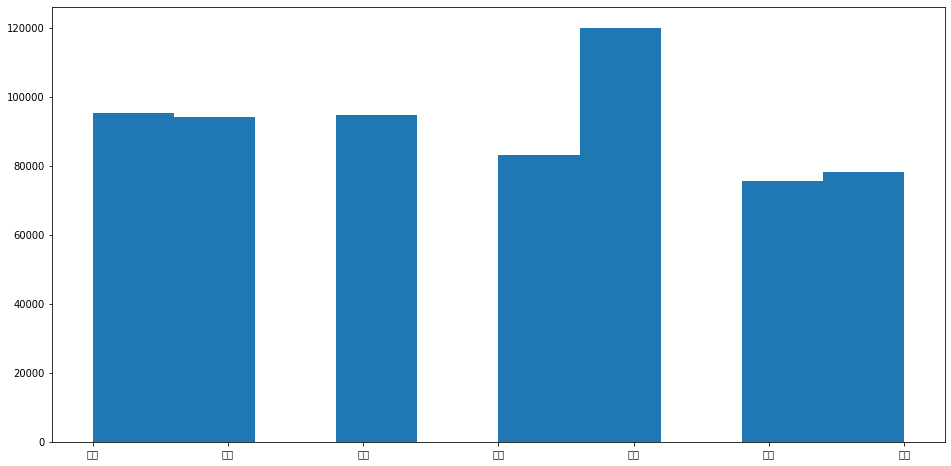

In [10]:
label = df['지능']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

## Train Test Split

In [13]:
X = df.답변
y = df.지능

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [14]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (512946,)
y_train shape:  (512946,)

X_test shape:  (128237,)
y_test shape:  (128237,)


## Preprocessing

### Train Tokenization

In [15]:
komoran = Komoran()

# 불용어(Stop Words) 제거
stop_pos_tags = ['IC', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX',
                   'EF', 'ETN', 'ETM', 'XSA', 'SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH',
                   'SW', 'NF', 'NV', 'SN', 'NA']

# 어간 원형 복원(Lemmatization)
# 동사와 형용사의 경우에는 어간(Stem)에 '다'를 붙여서 기본형으로 복원
def tokenize(corpus, stop_pos_tags):
    result = []
    pairs = komoran.pos(corpus)
    for pair in pairs:
        morph, pos = pair
        if pos not in stop_pos_tags:
            if pos in ['VV', 'VA', 'VX', 'VCP', 'VCN']:
                morph = morph + '다'
            result.append(morph)
    return result

In [16]:
# 토큰을 만들고 리스트에 저장
clean_train_text = []
for sample in tqdm(X_train):
    clean_train_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 512946/512946 [03:34<00:00, 2392.65it/s]


In [17]:
clean_train_text[:3]

[['조', '소설집', '이야기', '상상', '하', '게', '조금', '행복', '하', '아'],
 ['태평소', '연주', '하', '면서', '노래', '부르다', '게', '기쁘다', '어'],
 ['구경', '하', '게', '잔디', '을', '좋다', '아']]

### Test Tokenization

In [18]:
# 토큰을 만들고 리스트에 저장
clean_test_text = []
for sample in tqdm(X_test):
    clean_test_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 128237/128237 [00:59<00:00, 2150.50it/s]


### Vectorization

In [19]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token=True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)

except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

print(train_sequences[:3])

[[66, 211, 39, 93, 3, 2, 27, 13, 3, 5], [456, 40, 3, 17, 101, 110, 2, 16, 4], [48, 3, 2, 1136, 36, 8, 5]]


### Set vocab_size

In [20]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

1927


### Get vocab items

In [21]:
token_dic = tokenizer.word_counts
d2 = sorted(token_dic.items(), key=lambda x: x[1], reverse=True)
print(d2)

[('게', 521465), ('하', 327509), ('어', 212861), ('아', 199815), ('잘', 106862), ('나', 102851), ('좋다', 81251), ('재밌다', 77491), ('되다', 77360), ('하다', 76657), ('거', 75456), ('행복', 74768), ('즐겁다', 73182), ('매우', 72570), ('기쁘다', 70235), ('면서', 64629), ('고', 63621), ('있다', 58994), ('신', 56209), ('아요', 49490), ('어요', 49131), ('친구', 46353), ('읽다', 45960), ('보다', 43527), ('그림', 41600), ('조금', 40317), ('진짜', 40292), ('엄청', 32912), ('좀', 31520), ('너무', 31452), ('꽤', 31446), ('항상', 31321), ('정말', 31302), ('주다', 30320), ('을', 29589), ('그리다', 27370), ('만들다', 26091), ('이야기', 25582), ('연주', 25484), ('듣다', 24859), ('수', 24671), ('소리', 23799), ('놓다', 23500), ('지다', 23408), ('는지', 22999), ('꿈', 22412), ('구경', 22046), ('어서', 20624), ('관찰', 19802), ('때', 19759), ('배우다', 19575), ('속', 19208), ('엄마', 18683), ('지', 17997), ('신나다', 17523), ('뛰다', 17044), ('요', 16683), ('이다', 16663), ('들', 16373), ('아빠', 15563), ('그릴', 15498), ('뭔', 15328), ('과', 14818), ('섞다', 13721), ('조', 13498), ('쓰다', 12754), ('시간', 11978), ('

### Padding

텍스트의 최대 길이 : 49
텍스트의 평균 길이 : 9.58612407543874


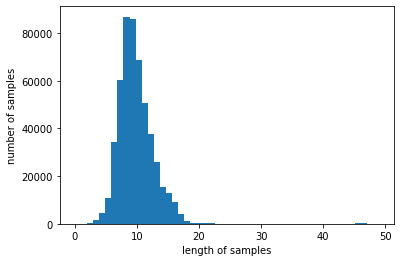

In [22]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [23]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = int(max(len(text) for text in train_sequences) * 95 / 100)

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

## Labeling

In [24]:
y_train.unique()

array(['언어', '음악', '자연', '관계', '미술', '신체', '수리'], dtype=object)

In [25]:
intelli_dic = {
    '관계': 0, '미술': 1, '수리': 2, '신체': 3, '언어': 4, '음악': 5, '자연': 6
}

In [26]:
y_train = y_train.replace(intelli_dic)
y_test = y_test.replace(intelli_dic)
y_train.unique()

array([4, 5, 6, 0, 1, 3, 2])

## Model definition

In [27]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, mask_zero=True, input_length=MAX_LEN))
model.add(LSTM(units=UNITS, dropout=DROPOUT))#, recurrent_dropout=RECURRENT_DROPOUT))
model.add(Dense(units=OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR + 'best-model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train

In [28]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es, mcp], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT
)

Epoch 1/10
3200/3206 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9814
Epoch 1: val_accuracy improved from -inf to 0.99508, saving model to /content/drive/MyDrive/miso/new_intelli/model/LSTM_eda/best-model.h5
3206/3206 [==============================] - 51s 10ms/step - loss: 0.0598 - accuracy: 0.9814 - val_loss: 0.0148 - val_accuracy: 0.9951
Epoch 2/10
3201/3206 [============================>.] - ETA: 0s - loss: 0.0123 - accuracy: 0.9960
Epoch 2: val_accuracy improved from 0.99508 to 0.99614, saving model to /content/drive/MyDrive/miso/new_intelli/model/LSTM_eda/best-model.h5
3206/3206 [==============================] - 27s 8ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.0118 - val_accuracy: 0.9961
Epoch 3/10
3204/3206 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9966
Epoch 3: val_accuracy improved from 0.99614 to 0.99639, saving model to /content/drive/MyDrive/miso/new_intelli/model/LSTM_eda/best-model.h5
3206/3206 [======

## Test

In [29]:
loaded_model = load_model(LOAD_DIR + 'best-model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)
print('Test loss: ', loss)
print('Test accuracy: ', acc)

4008/4008 [==============================] - 18s 4ms/step - loss: 0.0075 - accuracy: 0.9975
Test loss:  0.007453715428709984
Test accuracy:  0.997473418712616


## Visualization

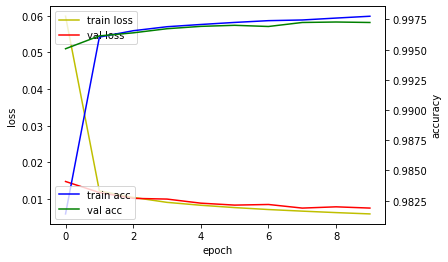

In [30]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Save model

In [31]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/miso/new_intelli/model/LSTM_eda/trained-model.h5 


## Evaluation

In [32]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

[4 1 6 ... 1 6 5]


### Confusion matrix

[[19007     1     6    26     4     1     1]
 [    2 18819    11     8     4     1     3]
 [    7     4 18863    66    18     5     4]
 [   10     4    29 16554     7     1     6]
 [    2     3     3    32 23967     0     3]
 [    1     1     9    11     4 15105     0]
 [    3     0     5    15     3     0 15598]]


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44288 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44228 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49696 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_

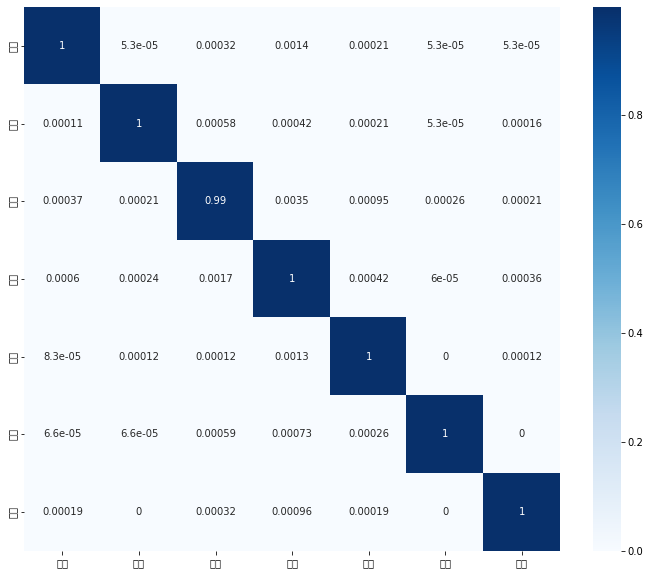

In [33]:
# constant for classes
classes = ('관계', '미술', '수리', '신체', '언어', '음악', '자연')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(7, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + '/output.png')

### precision, recall, f1 score

In [34]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.9974734281057729
precision_score:  0.9974184067152866
recall_score:  0.9974750969766524
f1_score:  0.9974451734715457


## Load Model

In [35]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained-model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [36]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_label(text, model):
    tokens = []
    tokenized = tokenize(text, stop_pos_tags)
    if(len(tokenized) == 0) :
        return "너무 짧아"
    tokens.append(tokenized)
    tokens = tokenizer.texts_to_sequences(tokens)
    x_test = pad_sequences(tokens, maxlen=MAX_LEN)
    predict = model.predict(x_test)
    # print(predict)
    result = getResult(predict[0])
    # '관계', '미술', '수리', '신체', '언어', '음악', '자연'
    if result == 0 :
        return '관계'
    elif result == 1 :
        return '미술'
    elif result == 2 :
        return '수리'
    elif result == 3 :
        return '신체'
    elif result == 4 :
        return '언어'
    elif result == 5 :
        return '음악'
    elif result == 6 :
        return '자연'

## 3가지 레이블에 대한 예측

'미술' 라벨에 대한 예측

In [37]:
predict_label("나는 동물을 크레파스로 그리는게 신나", model)

'미술'

'관계' 라벨에 대한 예측

In [38]:
predict_label("나는 친구를 도와줘서 칭찬을 받는게 좋아", model)

'관계'

'수리'라벨에 대한 예측

In [39]:
predict_label("나는 숫자를 공부해서 나중에 프로그래머가 되고 싶어요", model)

'수리'